# SKILL CRAFT

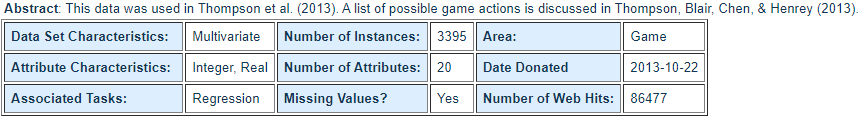

#### Attribute Information:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

#### Data Set Information:

- We aggregated screen movements into screen-fixations using a Salvucci & Goldberg (2000) dispersion-threshold algorithm, and defined Perception Action Cycles (PACs) as fixations with at least one action.
- Time is recorded in terms of timestamps in the StarCraft 2 replay file. When the game is played on 'faster', 1 real-time second is equivalent to roughly 88.5 timestamps.
- List of possible game actions is discussed in Thompson, Blair, Chen, & Henrey (2013)


In [2]:
# import most of libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [3]:
# load the dataset
columns = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
target_col = columns.index(5)
dataset = pd.read_csv('data/SkillCraft1_Dataset.csv', usecols=columns)

# convert DataFrame to numpy
# the data has missing value
dataset_array = dataset.to_numpy()[:,:]
print(dataset_array)

[[52 5 '27' ... 6 0.0 0.0]
 [55 5 '23' ... 5 0.0 0.00020757]
 [56 4 '30' ... 6 0.0 0.00018876]
 ...
 [10092 8 '?' ... 4 0.0 0.0]
 [10094 8 '?' ... 6 0.0 0.00063141]
 [10095 8 '?' ... 7 0.000456868 0.00089509]]


### DELETE DUPLICATED RECORDS

In [4]:
# delete duplicated elements
dataset_array = np.delete(dataset_array, np.unique(np.where(dataset_array == '?')[0]), axis=0)

In [5]:
# create train samples
train_dataset , test_dataset = train_test_split(dataset_array, shuffle = True, random_state = 42, train_size = 0.8)

### Noramlize

In [6]:
# instanciate a scaler
sc = StandardScaler()

# fetch labels
train_labels = train_dataset[:,target_col].astype('float32')

# delete the labels from the samples
train_samples = np.delete(train_dataset, target_col, axis=1)
train_samples = np.delete(train_samples, 0, axis=1)

print(train_samples)

# normalize
scaled_train_samples = sc.fit_transform(train_samples).astype('float32')

[[4 '26' '6' ... 9 0.000225946 0.00048665]
 [5 '20' '24' ... 4 0.0 0.0]
 [5 '18' '42' ... 9 0.0 0.0]
 ...
 [4 '21' '12' ... 7 0.0 0.0]
 [5 '17' '42' ... 9 7.87e-05 0.00030514]
 [3 '40' '16' ... 5 0.0 0.0]]


In [7]:
print(scaled_train_samples)

[[-0.05794376  1.0248634  -0.82102466 ...  1.3360084   1.4856381
   1.3087919 ]
 [ 0.6327252  -0.3888021   0.6876717  ... -1.3460536  -0.53362244
  -0.5352336 ]
 [ 0.6327252  -0.8600239   2.1963682  ...  1.3360084  -0.53362244
  -0.5352336 ]
 ...
 [-0.05794376 -0.15319121 -0.31812587 ...  0.26318362 -0.53362244
  -0.5352336 ]
 [ 0.6327252  -1.0956348   2.1963682  ...  1.3360084   0.16971292
   0.62101   ]
 [-0.7486127   4.323416    0.01714    ... -0.8096412  -0.53362244
  -0.5352336 ]]


## Build The Model

we used Sequential Model for our MLP.

In [8]:
model = Sequential([
    Dense(units=128, input_shape=(train_samples.shape[1],), activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='linear')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________


### compile the model (preprocessing)

In [10]:
# model.compile(
#     optimizer=Adam(learning_rate=0.01), 
#     loss='mean_absolute_error', 
#     metrics=['mean_absolute_error']
# )

model.compile(
    optimizer=RMSprop(), 
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

### Train the model

In [11]:
history = model.fit(x=scaled_train_samples, y=train_labels, validation_split=0.1, batch_size=128, epochs=100, shuffle=True, verbose=1)

Epoch 1/100
19/19 [==============================] - 1s 15ms/step - loss: 108.9025 - mean_absolute_error: 108.9025 - val_loss: 103.5057 - val_mean_absolute_error: 103.5057
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 85.7315 - mean_absolute_error: 85.7315 - val_loss: 66.3286 - val_mean_absolute_error: 66.3286
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 44.7332 - mean_absolute_error: 44.7332 - val_loss: 32.4170 - val_mean_absolute_error: 32.4170
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 26.8829 - mean_absolute_error: 26.8829 - val_loss: 25.4764 - val_mean_absolute_error: 25.4764
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 21.8546 - mean_absolute_error: 21.8546 - val_loss: 21.4965 - val_mean_absolute_error: 21.4965
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 18.9631 - mean_absolute_error: 18.9631 - val_loss: 19.6480 - val_mean_absolute_error: 1

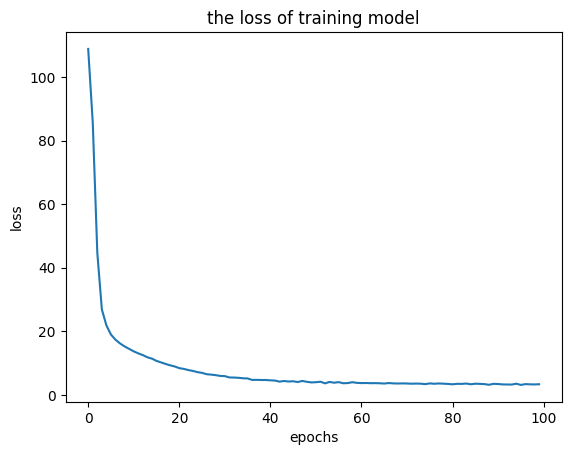

In [12]:
plt.plot(history.history['loss'])
plt.title('the loss of training model')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

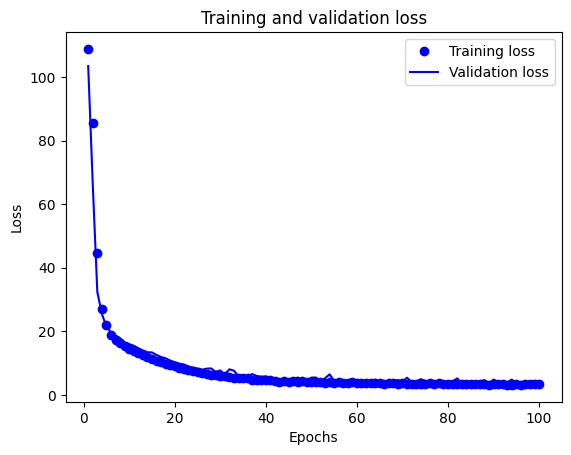

In [13]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### predict

In [14]:
# fetch labels
test_labels = test_dataset[:,target_col].astype('float32')

# delete the labels from the samples
test_samples = np.delete(test_dataset, target_col, axis=1)
test_samples = np.delete(test_samples, 0, axis=1)

print(test_samples)

# normalize
scaled_test_samples = sc.fit_transform(test_samples).astype('float32')

[[4 '20' '20' ... 7 0.0 5.67e-05]
 [4 '22' '4' ... 5 0.0 0.0]
 [3 '27' '14' ... 8 0.0 0.0]
 ...
 [3 '27' '16' ... 6 0.0 1.83e-05]
 [4 '18' '14' ... 7 0.0 0.0]
 [6 '20' '28' ... 5 0.0 0.0]]


In [15]:
predictions = model.predict(x=scaled_test_samples, batch_size=128, verbose=0)
#print(predictions)

## conclusions

In [16]:
def histogram(y_pred, y_true, n_rows = 1, n_cols = 1, title = 'barstacked'):

    species = ('1', '2')
    fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols)

    axs.hist(y_pred, density = True, histtype = 'barstacked', rwidth=0.8, label='y_pred')
    axs.hist(y_true, density = True, histtype = 'barstacked', rwidth=0.8, label='y_true')
    axs.set_title(title)
    
    axs.set_ylabel('action-per-minute')
    axs.legend(loc='upper left', ncols=2)

    fig.tight_layout()
    plt.show()

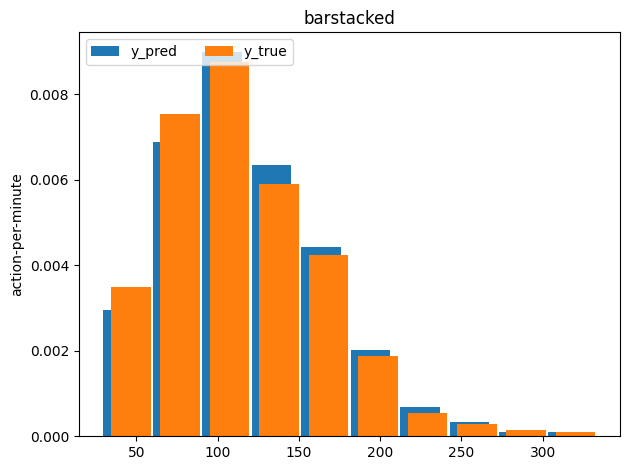

In [17]:
histogram(y_pred = predictions, y_true = test_labels)

In [18]:
def group_bar_chart(species, y_pred, y_true):
    
    penguin_means = {
        'y_pred': np.squeeze(y_pred),
        'y_true': np.squeeze(y_true),
    }

    x = np.arange(len(species))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(1, 1)

    for attribute, measurement in penguin_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (mm)')
    ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(species)
    ax.legend(loc='upper left', ncol=2)

    plt.show()

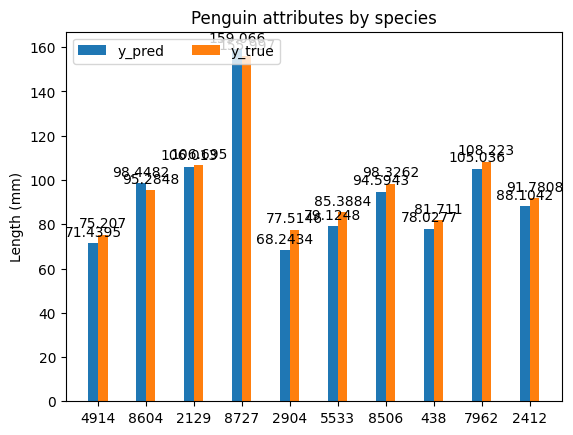

In [19]:
# set offset and limitation
offset = 0
limit = 10

limit = min(offset + limit, len(test_dataset))

# rows
tdataset = np.array([])
tdataset = np.append(arr = tdataset, values = test_dataset[offset : (limit + offset),0])

# predicted datas
predict = np.array([])
predict = np.append(arr = predict, values = predictions[offset : (limit + offset),0])
    
# true datas
targets = np.array([])
targets = np.append(arr = targets, values = test_labels[offset : (limit + offset)])

# print chart
group_bar_chart(species = tdataset, y_pred = predict, y_true = targets)

In [61]:
import itertools

# define a function to display the confusion metrics with sklearn
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True' .
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicated label')

### Confusion matrics

In [72]:
from sklearn.metrics import confusion_matrix

In [93]:
def convert_to_classification(predictions, test_labels, threshold):
    # Create an empty array for the classification labels
    labels = np.zeros_like(predictions)
    
    # Assign labels based on the threshold
    for i in range(len(predictions)):
        if (predictions[i] - test_labels[i] <= threshold):
            labels[i] = 1
    
    return labels

In [103]:
# create true labels
regression_labels = np.array([])
for i in range(len(test_labels)):
    regression_labels = np.append(regression_labels, [1])

# create classification_labels
threshold = 2
classification_labels = convert_to_classification(predictions, test_labels, threshold)

In [104]:
# build the confusion metrics
cm = confusion_matrix(y_true=regression_labels, y_pred=classification_labels)

Confusion matrix, without normalization
[[  0   0]
 [178 490]]


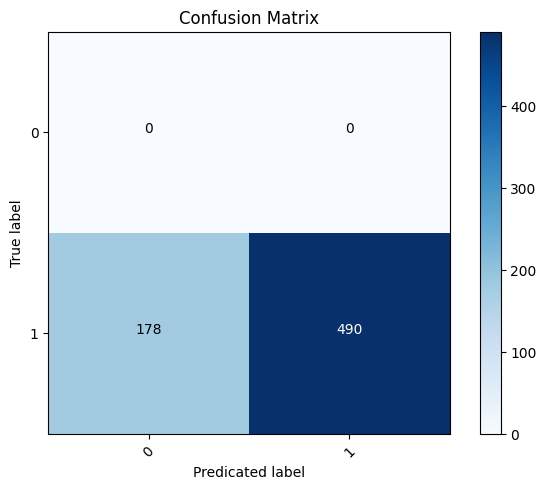

In [105]:
plot_confusion_matrix(cm=cm, classes=[0,1], title='Confusion Matrix')

### F1 score matrics

In [32]:
def calculate_f1_score(true_positives = 0, false_positives = 0, false_negatives = 0):
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

### Build the model2

In [123]:
model2 = Sequential([
    Dense(units=16, input_shape=(train_samples.shape[1],), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='relu')
])

### compile the model

In [124]:
model2.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

### Train the model

In [112]:
history = model2.fit(x=scaled_train_samples, y=train_labels, validation_split=0.2, batch_size=64, epochs=150, shuffle=True, verbose=1)

Epoch 1/150
34/34 [==============================] - 2s 28ms/step - loss: 59.1441 - mean_absolute_error: 59.1441 - val_loss: 24.7866 - val_mean_absolute_error: 24.7866
Epoch 2/150
34/34 [==============================] - 0s 4ms/step - loss: 18.0697 - mean_absolute_error: 18.0697 - val_loss: 14.7515 - val_mean_absolute_error: 14.7515
Epoch 3/150
34/34 [==============================] - 0s 4ms/step - loss: 12.3627 - mean_absolute_error: 12.3627 - val_loss: 11.0430 - val_mean_absolute_error: 11.0430
Epoch 4/150
34/34 [==============================] - 0s 4ms/step - loss: 9.5724 - mean_absolute_error: 9.5724 - val_loss: 8.1622 - val_mean_absolute_error: 8.1622
Epoch 5/150
34/34 [==============================] - 0s 4ms/step - loss: 8.1470 - mean_absolute_error: 8.1470 - val_loss: 8.6169 - val_mean_absolute_error: 8.6169
Epoch 6/150
34/34 [==============================] - 0s 4ms/step - loss: 6.9588 - mean_absolute_error: 6.9588 - val_loss: 6.9117 - val_mean_absolute_error: 6.9117
Epoch 7/1

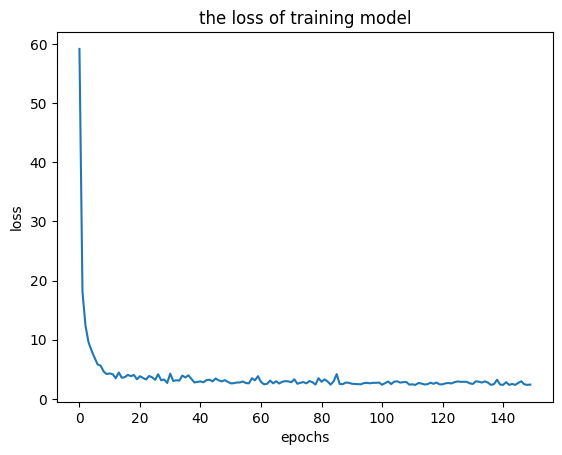

In [113]:
plt.plot(history.history['loss'])
plt.title('the loss of training model')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

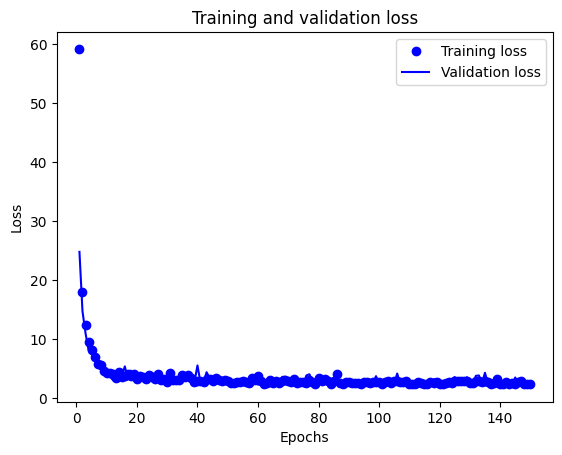

In [114]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### predict

In [120]:
predictions2 = model2.predict(x=scaled_test_samples, batch_size=64, verbose=0)
#print(predictions2)

### Conclusions

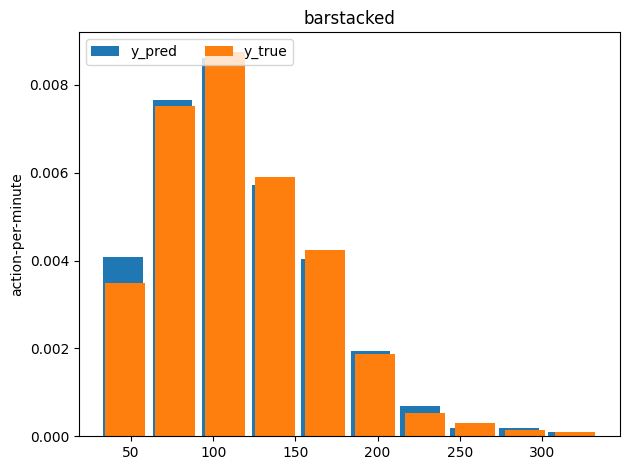

In [121]:
histogram(y_pred = predictions2, y_true = test_labels)

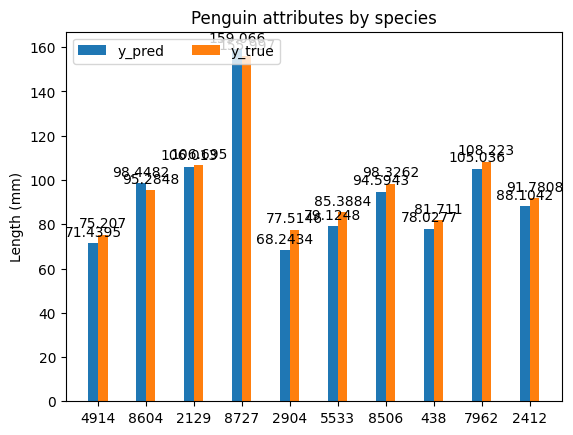

In [122]:
# set offset and limitation
offset = 0
limit = 10

limit = min(offset + limit, len(test_dataset))

# rows
tdataset2 = np.array([])
tdataset2 = np.append(arr = tdataset, values = test_dataset[offset : (limit + offset),0])

# predicted datas
predict2 = np.array([])
predict2 = np.append(arr = predict, values = predictions2[offset : (limit + offset),0])
    
# true datas
targets2 = np.array([])
targets2 = np.append(arr = targets, values = test_labels[offset : (limit + offset)])

# print chart
group_bar_chart(species = tdataset, y_pred = predict, y_true = targets)